In [305]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [306]:
import seaborn as sns
sns.set()

In [307]:
df = pd.read_excel("/Users/michaelzhang/Desktop/pnet_features/pnet-ep_sp_t1t2.xlsx")

In [308]:
df.head()

,path,subgroup,seg_id,id,gender,age,institution,t1_log-sigma-1-mm-3D_firstorder_10Percentile,t1_log-sigma-1-mm-3D_firstorder_90Percentile,t1_log-sigma-1-mm-3D_firstorder_Energy,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,pnet,atrt,SEG_CG_SP-ATRT_U_0001_t1--1,CG_SP-ATRT_U_0001,M,34.12,CG,-15.728235,7.777033,3.945519e+05,...,0.019436,0.001898,701.708955,0.436386,0.686810,1946.93239,0.001527,7.814229,0.466357,9.691870
1,pnet,atrt,SEG_CG_SP-ATRT_U_0002_t1--2,CG_SP-ATRT_U_0002,F,29.00,CG,-6.158685,8.308620,1.481480e+06,...,0.104908,0.000492,5996.119050,0.441443,0.691067,3477.66179,0.000372,8.370138,0.341402,285.946015
2,pnet,atrt,SEG_CG_SP-ATRT_U_0003_t1--3,CG_SP-ATRT_U_0003,M,31.63,CG,-4.662733,6.153834,4.439722e+06,...,0.263167,0.000312,15620.264100,0.423842,0.676668,4767.11018,0.000233,8.504460,0.286178,1039.856470
3,pnet,atrt,SEG_CG_SP-ATRT_U_0004_t1--4,CG_SP-ATRT_U_0004,M,20.48,CG,-8.639307,8.268157,2.530302e+06,...,2.972597,0.001266,4862.256530,0.418007,0.672263,2111.51157,0.000787,8.306622,0.267562,2083.198260
4,pnet,atrt,SEG_CG_SP-ATRT_U_0005_t1--5,CG_SP-ATRT_U_0005,M,13.87,CG,-21.986884,10.653808,6.792327e+06,...,0.058764,0.000807,7886.977530,0.495009,0.731430,3791.45810,0.000485,8.419626,0.483712,24.828265


In [309]:
reduced_features = pd.read_excel("/Users/michaelzhang/Desktop/pnet_features/pnet-ep_LASSO.xlsx")

In [310]:
reduced_features_list = reduced_features.loc[reduced_features['pnet-ep'].isnull() == False, ['pnet-ep']].values.tolist()

In [311]:
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [312]:
reduced_features_list

['t1_log-sigma-1-mm-3D_glcm_Imc2',
 't1_wavelet-HLL_firstorder_Skewness',
 't2_log-sigma-5-mm-3D_firstorder_Median',
 't2_wavelet-LLL_firstorder_Kurtosis']

In [313]:
target = df["path"]

In [314]:
target.value_counts()

ep      55
pnet    50
Name: path, dtype: int64

In [315]:
#Marking 0 as hgg and 1 pnet
mapping_dict = {0: 'pnet', 1: 'ep'} ##
target = target.map(dict(pnet = 0, ep = 1)) ##

In [316]:
features_after_lasso = df[reduced_features_list]

In [317]:
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)

In [318]:
y_train.value_counts()

1    42
0    36
Name: path, dtype: int64

In [319]:
y_test.value_counts()

0    14
1    13
Name: path, dtype: int64

In [320]:
NIR = 50/105
NIR

0.47619047619047616

# Resampling to Correct for Imbalance

In [321]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['path'] == 0]
X_1 = X[X['path'] == 1]

In [322]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [323]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

In [324]:
y_train.value_counts()

1    42
0    42
Name: path, dtype: int64

# Standardizing Features

In [325]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [326]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [327]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

In [328]:
def create_ci(bootstrapped_scores, name):
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print("95% Confidence interval for the {} score: [{:0.4f} - {:0.4}]".format(name, 
    confidence_lower, confidence_upper))

In [329]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TN / (TN + FP)

In [330]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [331]:
def negative_pv_score(y_true, y_pred):
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN)        

# SVM

### Grid Search for Hyperparameters

In [332]:
svm_model = svm.SVC()
grid_param = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']
}

svm_grid = GridSearchCV(estimator=svm_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [333]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             scoring='accuracy')

In [334]:
print(svm_grid.best_params_)

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


### Model Performance

In [335]:
svm_model = svm.SVC(C = 1, gamma = 1, kernel = 'rbf', probability = True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [336]:
y_train_pred = svm_model.predict(X_train)

In [337]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

print("PPV Score: " + str(positive_pv_score(y_test.to_numpy(), y_pred)))
print("NPV Score: " + str(negative_pv_score(y_test.to_numpy(), y_pred)))


Accuracy Score: 0.5925925925925926
Specificity Score: 0.42857142857142855
Precision: 0.5555555555555556
Recall: 0.7692307692307693
F1 Score: 0.6451612903225806
PPV Score: 0.5555555555555556
NPV Score: 0.6666666666666666


In [338]:
svm_probs = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
auc = roc_auc_score(y_test, svm_probs)
print("AUC: " + str(auc))

AUC: 0.7472527472527473


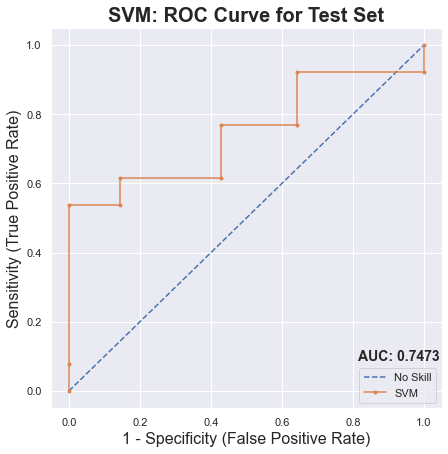

In [339]:
plt.figure(figsize=(7, 7)) ##

ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVM')
plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

plt.legend(loc='lower right')
plt.title('SVM: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
short_auc = round(auc,4)
plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
plt.show()

In [340]:
#sns.reset_orig()

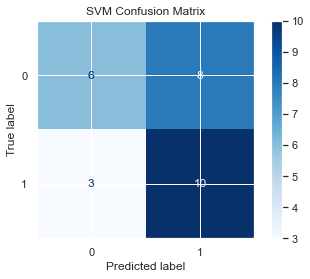

In [341]:
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show(matrix)
plt.show()

In [342]:
#n_bootstraps = 2000
#rng_seed = 42  # control reproducibility
#bootstrapped_auc_scores = []
#bootstrapped_acc_scores = []
#bootstrapped_spec_scores = []
#bootstrapped_prec_scores = []
#bootstrapped_rec_scores = []
#bootstrapped_f1_scores = []
#bootstrapped_ppv_scores = []
#bootstrapped_npv_scores = []

#rng = np.random.RandomState(rng_seed)
#for i in range(n_bootstraps):
#    # bootstrap by sampling with replacement on the prediction indices
#    indices = rng.randint(0, len(svm_probs), len(svm_probs))
#    if len(np.unique(y_test.to_numpy()[indices])) < 2:
#        # We need at least one positive and one negative sample for ROC AUC
#        # to be defined: reject the sample
#        continue

#    auc_score = roc_auc_score(y_test.to_numpy()[indices], svm_probs[indices])
#    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
#    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
#    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
#    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
#    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))
#    ppv_score = positive_pv_score(y_test.to_numpy()[indices], y_pred[indices])
#    npv_score = negative_pv_score(y_test.to_numpy()[indices], y_pred[indices])

#    bootstrapped_auc_scores.append(auc_score)
#    bootstrapped_acc_scores.append(acc_score)
#    bootstrapped_spec_scores.append(spec_score)
#    bootstrapped_prec_scores.append(prec_score)
#    bootstrapped_rec_scores.append(rec_score)
#    bootstrapped_f1_scores.append(f_one_score)
#    bootstrapped_ppv_scores.append(ppv_score)
#    bootstrapped_npv_scores.append(npv_score)

In [343]:
#plt.hist(bootstrapped_auc_scores, bins=50)
#plt.title('Histogram of the bootstrapped ROC AUC scores')
#plt.show()

In [344]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f1_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV")
#create_ci(bootstrapped_npv_scores, "NPV")

# Logistic Regression

### Grid Search for Hyperparameters

In [345]:
lr_model = LogisticRegression()
grid_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [10, 1, 0.1, 0.01, 0.001]
}

lr_grid = GridSearchCV(estimator=lr_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [346]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='accuracy')

In [347]:
print(lr_grid.best_params_)

{'C': 0.01, 'penalty': 'l2'}


### Model Performance

In [348]:
lr_model = LogisticRegression(penalty = 'l2', C = 1)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [349]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

print("PPV Score: " + str(positive_pv_score(y_test.to_numpy(), y_pred)))
print("NPV Score: " + str(negative_pv_score(y_test.to_numpy(), y_pred)))


Accuracy Score: 0.7777777777777778
Specificity Score: 0.8571428571428571
Precision: 0.8181818181818182
Recall: 0.6923076923076923
F1 Score: 0.7500000000000001
PPV Score: 0.8181818181818182
NPV Score: 0.75


In [350]:
lr_probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
auc = roc_auc_score(y_test, lr_probs)
print("AUC: " + str(auc))

AUC: 0.8406593406593407


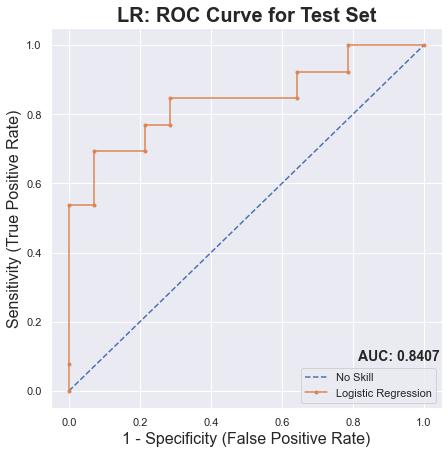

In [351]:
plt.figure(figsize=(7, 7)) ##

ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

plt.legend(loc='lower right')
plt.title('LR: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
short_auc = round(auc,4)
plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
plt.show()

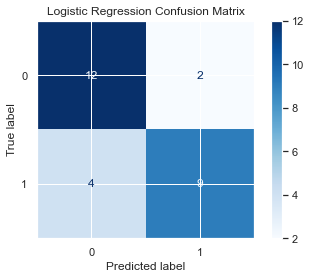

In [352]:
matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

In [353]:
#n_bootstraps = 2000
#rng_seed = 42  # control reproducibility
#bootstrapped_auc_scores = []
#bootstrapped_acc_scores = []
#bootstrapped_spec_scores = []
#bootstrapped_prec_scores = []
#bootstrapped_rec_scores = []
#bootstrapped_f1_scores = []
#bootstrapped_ppv_scores = []
#bootstrapped_npv_scores = []

#rng = np.random.RandomState(rng_seed)
#for i in range(n_bootstraps):
#    # bootstrap by sampling with replacement on the prediction indices
#    indices = rng.randint(0, len(svm_probs), len(svm_probs))
#    if len(np.unique(y_test.to_numpy()[indices])) < 2:
#        # We need at least one positive and one negative sample for ROC AUC
#        # to be defined: reject the sample
#        continue

#    auc_score = roc_auc_score(y_test.to_numpy()[indices], svm_probs[indices])
#    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
#    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
#    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
#    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
#    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))
#    ppv_score = positive_pv_score(y_test.to_numpy()[indices], y_pred[indices])
#    npv_score = negative_pv_score(y_test.to_numpy()[indices], y_pred[indices])

#    bootstrapped_auc_scores.append(auc_score)
#    bootstrapped_acc_scores.append(acc_score)
#    bootstrapped_spec_scores.append(spec_score)
#    bootstrapped_prec_scores.append(prec_score)
#    bootstrapped_rec_scores.append(rec_score)
#    bootstrapped_f1_scores.append(f_one_score)
#    bootstrapped_ppv_scores.append(ppv_score)
#    bootstrapped_npv_scores.append(npv_score)

In [354]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f1_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV")
#create_ci(bootstrapped_npv_scores, "NPV")

In [355]:
#feature_labels_dict = {'t1_original_shape_Elongation': 'T1 Original Shape Elongation', 
#                      't2_log-sigma-5-mm-3D_firstorder_90Percentile': 'T2 Log Sigma 5mm 3D 90th Percentile (1st Order)',
#                          't2_original_shape_Elongation': 'T2 Original Shape Elongation',
#                          't2_original_shape_Flatness': 'T2 Original Shape Flatness',
#                      't2_wavelet-LLL_glcm_Idmn': 'T2 Wavelet LLL Glcm Idmn',
#                      't2_wavelet-HLL_firstorder_Kurtosis': 'T2 Wavelet HLL Kurtosis (1st Order)',}

In [356]:
sns.set()

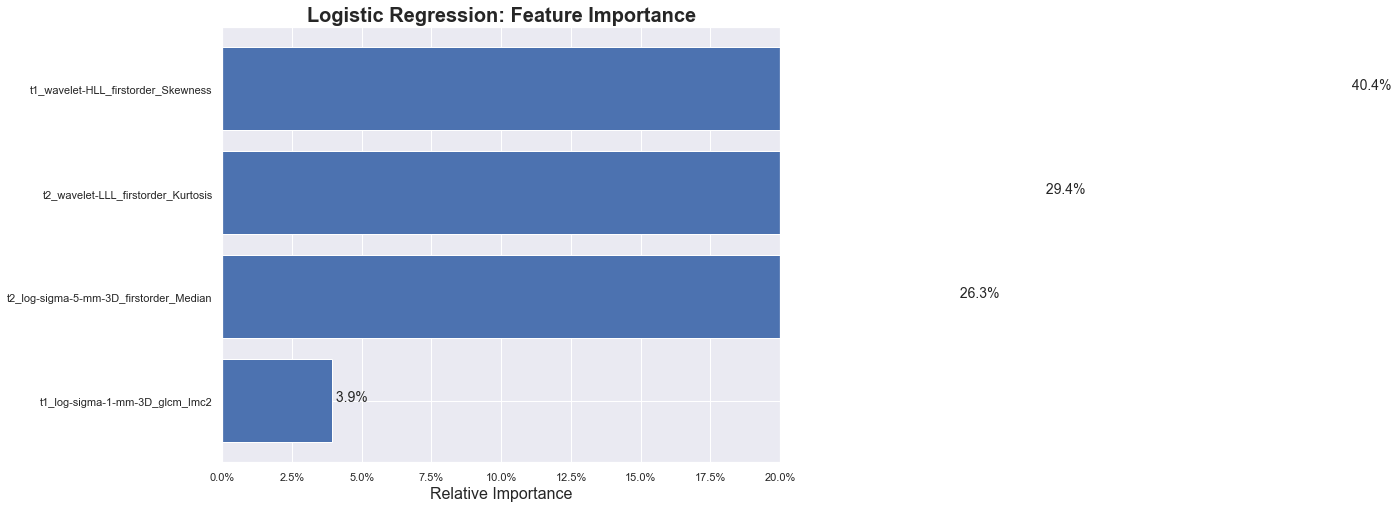

In [357]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Logistic Regression: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.20)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
#plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [358]:
#sns.reset_orig()

# KNN

### Grid Search for Hyperparameters

In [359]:
knn_model = KNeighborsClassifier()
grid_param = {'n_neighbors': [3, 5, 7, 9]
}

knn_grid = GridSearchCV(estimator=knn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [360]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='accuracy')

In [361]:
print(knn_grid.best_params_)

{'n_neighbors': 3}


### Model Performance

In [362]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [363]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

print("PPV Score: " + str(positive_pv_score(y_test.to_numpy(), y_pred)))
print("NPV Score: " + str(negative_pv_score(y_test.to_numpy(), y_pred)))


Accuracy Score: 0.6666666666666666
Specificity Score: 0.7142857142857143
Precision: 0.6666666666666666
Recall: 0.6153846153846154
F1 Score: 0.64
PPV Score: 0.6666666666666666
NPV Score: 0.6666666666666666


In [364]:
knn_probs = knn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
auc = roc_auc_score(y_test, knn_probs)
print("AUC: " + str(auc))

AUC: 0.6758241758241759


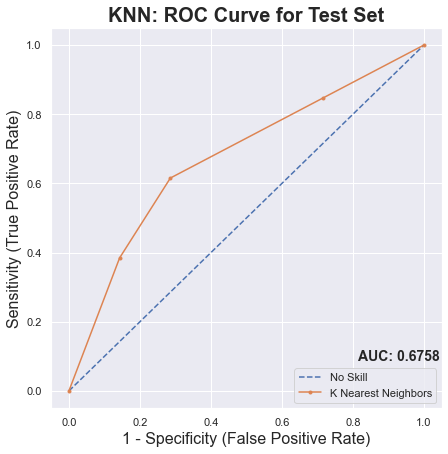

In [365]:
plt.figure(figsize=(7, 7)) ##

ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='K Nearest Neighbors')
plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

plt.legend(loc='lower right')
plt.title('KNN: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
short_auc = round(auc,4)
plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
plt.show()

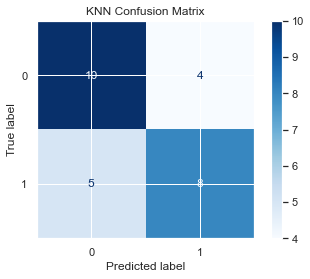

In [366]:
matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show(matrix)
plt.show()

In [367]:
#n_bootstraps = 2000
#rng_seed = 42  # control reproducibility
#bootstrapped_auc_scores = []
#bootstrapped_acc_scores = []
#bootstrapped_spec_scores = []
#bootstrapped_prec_scores = []
#bootstrapped_rec_scores = []
#bootstrapped_f1_scores = []
#bootstrapped_ppv_scores = []
#bootstrapped_npv_scores = []

#rng = np.random.RandomState(rng_seed)
#for i in range(n_bootstraps):
#    # bootstrap by sampling with replacement on the prediction indices
#    indices = rng.randint(0, len(svm_probs), len(svm_probs))
#    if len(np.unique(y_test.to_numpy()[indices])) < 2:
#        # We need at least one positive and one negative sample for ROC AUC
#        # to be defined: reject the sample
#        continue

#    auc_score = roc_auc_score(y_test.to_numpy()[indices], svm_probs[indices])
#    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
#    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
#    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
#    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
#    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))
#    ppv_score = positive_pv_score(y_test.to_numpy()[indices], y_pred[indices])
#    npv_score = negative_pv_score(y_test.to_numpy()[indices], y_pred[indices])

#    bootstrapped_auc_scores.append(auc_score)
#    bootstrapped_acc_scores.append(acc_score)
#    bootstrapped_spec_scores.append(spec_score)
#    bootstrapped_prec_scores.append(prec_score)
#    bootstrapped_rec_scores.append(rec_score)
#    bootstrapped_f1_scores.append(f_one_score)
#    bootstrapped_ppv_scores.append(ppv_score)
#    bootstrapped_npv_scores.append(npv_score)

In [368]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f1_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV")
#create_ci(bootstrapped_npv_scores, "NPV")

# Random Forest

### Grid Search for Hyperparameters
 

In [369]:
rf_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_grid = GridSearchCV(estimator=rf_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [370]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [371]:
print(rf_grid.best_params_)

{'max_depth': 4, 'n_estimators': 200}


### Model Performance

In [372]:
rf_model = RandomForestClassifier(max_depth = 3, n_estimators = 200, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [373]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

print("PPV Score: " + str(positive_pv_score(y_test.to_numpy(), y_pred)))
print("NPV Score: " + str(negative_pv_score(y_test.to_numpy(), y_pred)))


Accuracy Score: 0.8888888888888888
Specificity Score: 0.9285714285714286
Precision: 0.9166666666666666
Recall: 0.8461538461538461
F1 Score: 0.8799999999999999
PPV Score: 0.9166666666666666
NPV Score: 0.8666666666666667


In [374]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc = roc_auc_score(y_test, rf_probs)
print("AUC: " + str(auc))

AUC: 0.8956043956043958


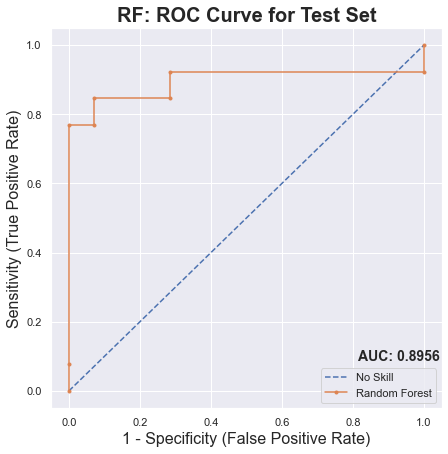

In [375]:
plt.figure(figsize=(7, 7)) ##

ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

plt.legend(loc='lower right')
plt.title('RF: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
short_auc = round(auc,4)
plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
plt.show()

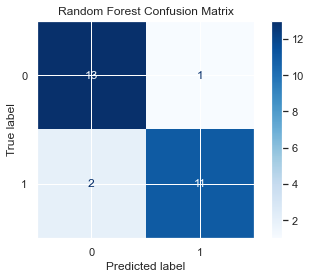

In [376]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

In [377]:
#n_bootstraps = 2000
#rng_seed = 42  # control reproducibility
#bootstrapped_auc_scores = []
#bootstrapped_acc_scores = []
#bootstrapped_spec_scores = []
#bootstrapped_prec_scores = []
#bootstrapped_rec_scores = []
#bootstrapped_f1_scores = []
#bootstrapped_ppv_scores = []
#bootstrapped_npv_scores = []

#rng = np.random.RandomState(rng_seed)
#for i in range(n_bootstraps):
#    # bootstrap by sampling with replacement on the prediction indices
#    indices = rng.randint(0, len(svm_probs), len(svm_probs))
#    if len(np.unique(y_test.to_numpy()[indices])) < 2:
#        # We need at least one positive and one negative sample for ROC AUC
#        # to be defined: reject the sample
#        continue

#    auc_score = roc_auc_score(y_test.to_numpy()[indices], svm_probs[indices])
#    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
#    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
#    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
#    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
#    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))
#    ppv_score = positive_pv_score(y_test.to_numpy()[indices], y_pred[indices])
#    npv_score = negative_pv_score(y_test.to_numpy()[indices], y_pred[indices])

#    bootstrapped_auc_scores.append(auc_score)
#    bootstrapped_acc_scores.append(acc_score)
#    bootstrapped_spec_scores.append(spec_score)
#    bootstrapped_prec_scores.append(prec_score)
#    bootstrapped_rec_scores.append(rec_score)
#    bootstrapped_f1_scores.append(f_one_score)
#    bootstrapped_ppv_scores.append(ppv_score)
#    bootstrapped_npv_scores.append(npv_score)

In [378]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f1_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV")
#create_ci(bootstrapped_npv_scores, "NPV")

In [379]:
sns.set()

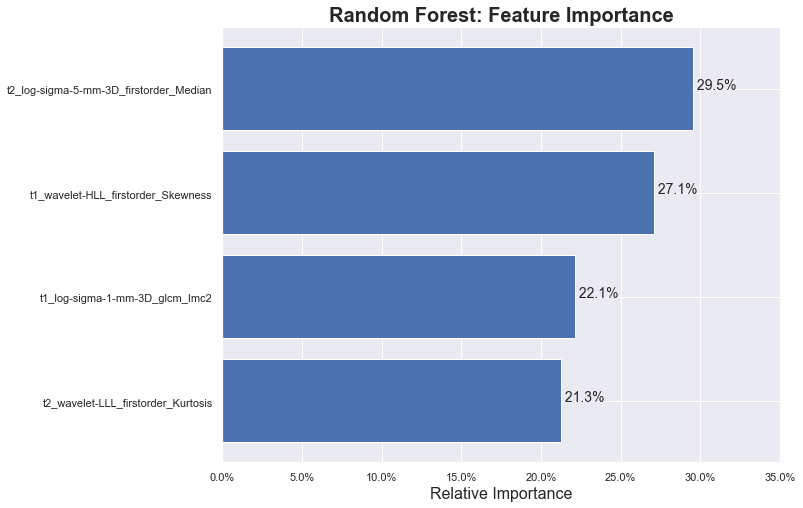

In [380]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Random Forest: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.35)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
#plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [381]:
#sns.reset_orig()

# XGBoost

### Grid Search for Hyperparameters

In [382]:
xgb_model = XGBClassifier(random_state = 42)
grid_param = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

xgb_grid = GridSearchCV(estimator=xgb_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [383]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [384]:
print(xgb_grid.best_params_)

{'learning_rate': 0.5, 'max_depth': 4}


### Model Performance

In [385]:
xgb_model = XGBClassifier(learning_rate = 0.5, max_depth = 4, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [386]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

print("PPV Score: " + str(positive_pv_score(y_test.to_numpy(), y_pred)))
print("NPV Score: " + str(negative_pv_score(y_test.to_numpy(), y_pred)))


Accuracy Score: 0.7407407407407407
Specificity Score: 0.7142857142857143
Precision: 0.7142857142857143
Recall: 0.7692307692307693
F1 Score: 0.7407407407407408
PPV Score: 0.7142857142857143
NPV Score: 0.7692307692307693


In [387]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc = roc_auc_score(y_test, xgb_probs)
print("AUC: " + str(auc))

AUC: 0.8296703296703297


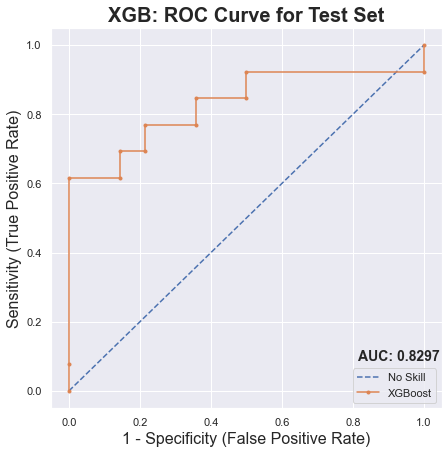

In [388]:
plt.figure(figsize=(7, 7)) ##

ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

plt.legend(loc='lower right')
plt.title('XGB: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
short_auc = round(auc,4)
plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
plt.show()

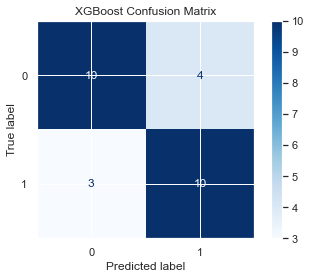

In [389]:
matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

In [390]:
#n_bootstraps = 2000
#rng_seed = 42  # control reproducibility
#bootstrapped_auc_scores = []
#bootstrapped_acc_scores = []
#bootstrapped_spec_scores = []
#bootstrapped_prec_scores = []
#bootstrapped_rec_scores = []
#bootstrapped_f1_scores = []
#bootstrapped_ppv_scores = []
#bootstrapped_npv_scores = []

#rng = np.random.RandomState(rng_seed)
#for i in range(n_bootstraps):
#    # bootstrap by sampling with replacement on the prediction indices
#    indices = rng.randint(0, len(svm_probs), len(svm_probs))
#    if len(np.unique(y_test.to_numpy()[indices])) < 2:
#        # We need at least one positive and one negative sample for ROC AUC
#        # to be defined: reject the sample
#        continue

#    auc_score = roc_auc_score(y_test.to_numpy()[indices], svm_probs[indices])
#    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
#    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
#    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
#    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
#    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))
#    ppv_score = positive_pv_score(y_test.to_numpy()[indices], y_pred[indices])
#    npv_score = negative_pv_score(y_test.to_numpy()[indices], y_pred[indices])

#    bootstrapped_auc_scores.append(auc_score)
#    bootstrapped_acc_scores.append(acc_score)
#    bootstrapped_spec_scores.append(spec_score)
#    bootstrapped_prec_scores.append(prec_score)
#    bootstrapped_rec_scores.append(rec_score)
#    bootstrapped_f1_scores.append(f_one_score)
#    bootstrapped_ppv_scores.append(ppv_score)
#    bootstrapped_npv_scores.append(npv_score)

In [391]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f1_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV")
#create_ci(bootstrapped_npv_scores, "NPV")

In [392]:
sns.set()

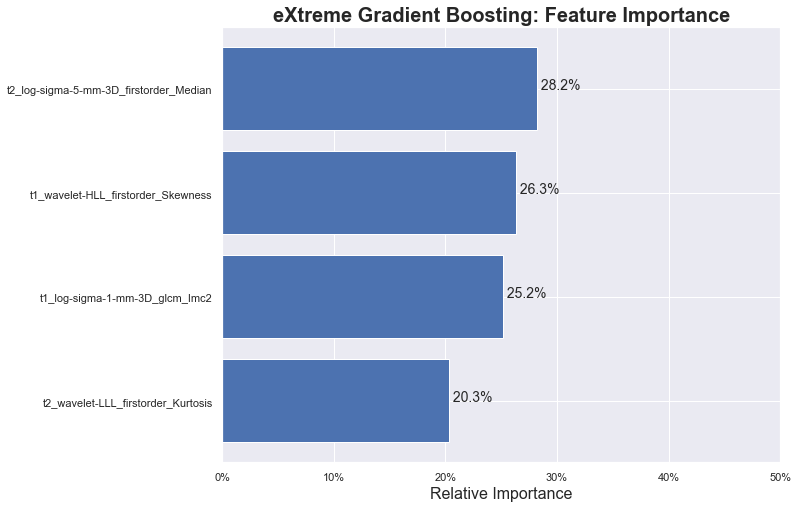

In [393]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('eXtreme Gradient Boosting: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.5)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
#plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [394]:
#sns.reset_orig()

# Neural Net

### Grid Search for Hyperparameters

In [395]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_grid = GridSearchCV(estimator=nn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [396]:
nn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [397]:
print(nn_grid.best_params_)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


### Model Performance

In [398]:
nn_model = MLPClassifier(hidden_layer_sizes = (50, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [399]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

print("PPV Score: " + str(positive_pv_score(y_test.to_numpy(), y_pred)))
print("NPV Score: " + str(negative_pv_score(y_test.to_numpy(), y_pred)))


Accuracy Score: 0.6666666666666666
Specificity Score: 0.5
Precision: 0.6111111111111112
Recall: 0.8461538461538461
F1 Score: 0.7096774193548387
PPV Score: 0.6111111111111112
NPV Score: 0.7777777777777778


In [400]:
nn_probs = nn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
auc = roc_auc_score(y_test, nn_probs)
print("AUC: " + str(auc))

AUC: 0.7252747252747254


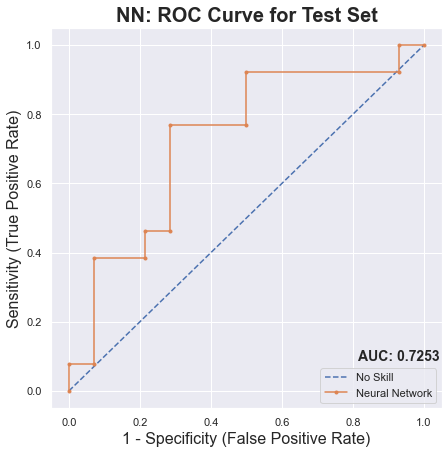

In [401]:
plt.figure(figsize=(7, 7)) ##

ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Neural Network')
plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

plt.legend(loc='lower right')
plt.title('NN: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
short_auc = round(auc,4)
plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
plt.show()

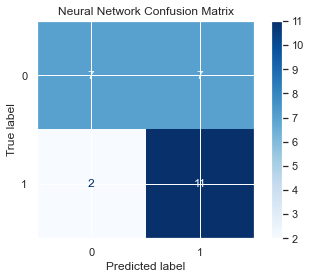

In [402]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

In [403]:
#n_bootstraps = 2000
#rng_seed = 42  # control reproducibility
#bootstrapped_auc_scores = []
#bootstrapped_acc_scores = []
#bootstrapped_spec_scores = []
#bootstrapped_prec_scores = []
#bootstrapped_rec_scores = []
#bootstrapped_f1_scores = []
#bootstrapped_ppv_scores = []
#bootstrapped_npv_scores = []

#rng = np.random.RandomState(rng_seed)
#for i in range(n_bootstraps):
#    # bootstrap by sampling with replacement on the prediction indices
#    indices = rng.randint(0, len(svm_probs), len(svm_probs))
#    if len(np.unique(y_test.to_numpy()[indices])) < 2:
#        # We need at least one positive and one negative sample for ROC AUC
#        # to be defined: reject the sample
#        continue

#    auc_score = roc_auc_score(y_test.to_numpy()[indices], svm_probs[indices])
#    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
#    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
#    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
#    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
#    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))
#    ppv_score = positive_pv_score(y_test.to_numpy()[indices], y_pred[indices])
#    npv_score = negative_pv_score(y_test.to_numpy()[indices], y_pred[indices])

#    bootstrapped_auc_scores.append(auc_score)
#    bootstrapped_acc_scores.append(acc_score)
#    bootstrapped_spec_scores.append(spec_score)
#    bootstrapped_prec_scores.append(prec_score)
#    bootstrapped_rec_scores.append(rec_score)
#    bootstrapped_f1_scores.append(f_one_score)
#    bootstrapped_ppv_scores.append(ppv_score)
#    bootstrapped_npv_scores.append(npv_score)

In [404]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f1_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV")
#create_ci(bootstrapped_npv_scores, "NPV")

In [405]:
metadata_df = df['path']
target_for_table = df['path']

metadata_df

features_for_table = df.drop(['path','subgroup','seg_id','id','institution'], axis = 1)
target_for_table = target_for_table.map(dict(pnet = 0, ep = 1))

target_for_table

X_train_for_table, X_test_for_table, _, _ = train_test_split(features_for_table, target_for_table, 
                                                    test_size = 0.25, random_state = 42)

X_train_for_table['Set'] = 'training'
X_test_for_table['Set'] = 'test'

X_for_table = pd.concat([X_train_for_table, X_test_for_table])
X_for_table = pd.merge(metadata_df, X_for_table, left_index = True, right_index = True)

final_df = X_for_table[['path', 'Set']]
features_for_table = df.drop(['path','subgroup','seg_id','id','institution'], axis = 1)
target_for_table = X_for_table['path']
target_for_table = target_for_table.map(dict(pnet = 0, ep = 1))

#features_for_table

X_table_reduced = features_for_table[reduced_features_list]

#sex_binarized = X_table_reduced['sex'].map(dict(M = 1, F = 0)).to_numpy()
#X_table_reduced['sex'] = sex_binarized

X_table_reduced

names = X_table_reduced.columns
X_table_for_probs = scaler.transform(X_table_reduced)
X_table_for_probs = pd.DataFrame(X_table_for_probs, columns = names)

y_probs = rf_model.predict_proba(X_table_for_probs)

rf_table = pd.DataFrame(y_probs, columns = ['PNET Prob','EP Prob'])

final_df['PNET Prob'] = rf_table['PNET Prob']
final_df['EP Prob'] = rf_table['EP Prob']


final_df['id'] = df['id']
final_df = final_df.round(4)

final_df
final_df.to_csv('rf_pnet-ep_classification_results.csv')

<ipython-input-405-71e58e8d7e50>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_for_table['Set'] = 'training'
<ipython-input-405-71e58e8d7e50>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_for_table['Set'] = 'test'
<ipython-input-405-71e58e8d7e50>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

# 